# Physical dynamics of a mass-spring system
This notebook and the accompanying code demonstrates how to use the Graph Nets library to learn to predict the motion of a set of masses connected by springs.

The network is trained to predict the behaviour of a chain of five masses, connected by identical springs. The first and last masses are fixed; the others are subject to gravity.

After training, the network's prediction ability is illustrated by comparing its output to the true behaviour of the structure. Then the network's ability to generalise is tested, by using it to predict the behaviour of a similar but more complicated mass/spring structure.

# Code

In [1]:
#@title Imports  { form-width: "30%" }

# The demo dependencies are not installed with the library, but you can install
# them with:
#
# $ pip install jupyter matplotlib scipy
#
# Run the demo with:
#
# $ jupyter notebook <path>/<to>/<demos>/shortest_path.ipynb
#tensorflow_version 1.x  # For Google Colab only.
#@title #### (Imports)
#tensorflow_version 2.x  # For Google Colab only.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks

from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf

from tensorflow.python.framework import ops

import time
# some_file.py
import imp


from matplotlib import pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import pickle
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/dmsm/m.colombo/Documents/graph_nets/graph_nets/demos_tf2')

import models
import blocks

try:
  import seaborn as sns
except ImportError:
  pass
else:
  sns.reset_orig()

SEED = 1
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

rand = np.random.RandomState(SEED)
suffix_pkl ='_4_9_dyn'

%matplotlib inline

In [2]:
#@title Helper functions  { form-width: "30%" }

# pylint: disable=redefined-outer-name
def normalize_el(el,var,mean):    
    #normalization of nodes and edges
    
    el= tf.math.divide(tf.math.subtract(el,mean),var)
    
    return el          

def denormalize_el(el,var,mean):    
    #normalization of nodes and edges
    
    el= tf.math.add(tf.math.multiply(el,var),mean)
    
    return el    


def normalize_graph(graph,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals):
    graph=graph.replace(nodes=normalize_el(graph.nodes,var_nodes,mean_nodes))
    graph=graph.replace(edges=normalize_el(graph.edges,var_edges,mean_edges))
    graph=graph.replace(globals=normalize_el(graph.globals,var_globals,mean_globals))
    
    return graph

def denormalize_graph(graph,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals):
    graph=graph.replace(nodes=denormalize_el(graph.nodes,var_nodes,mean_nodes))
    graph=graph.replace(edges=denormalize_el(graph.edges,var_edges,mean_edges))
    graph=graph.replace(globals=denormalize_el(graph.globals,var_globals,mean_globals))
    
    return graph


def base_graph(n, d):
  """Define a basic mass-spring system graph structure.

  These are n masses (1kg) connected by springs in a chain-like structure. The
  first and last masses are fixed. The masses are vertically aligned at the
  start and are d meters apart; this is also the rest length for the springs
  connecting them. Springs have spring constant 50 N/m and gravity is 10 N in
  the negative y-direction.

  Args:
    n: number of masses
    d: distance between masses (as well as springs' rest length)

  Returns:
    data_dict: dictionary with globals, nodes, edges, receivers and senders
        to represent a structure like the one above.
  """
  # Nodes
  # Generate initial position and velocity for all masses.
  # The left-most mass has is at position (0, 0); other masses (ordered left to
  # right) have x-coordinate d meters apart from their left neighbor, and
  # y-coordinate 0. All masses have initial velocity 0m/s.
  nodes = np.zeros((n, 5), dtype=np.float64)
  half_width = d * n / 2.0
  nodes[:, 0] = np.linspace(
      -half_width, half_width, num=n, endpoint=False, dtype=np.float64)
  # indicate that the first and last masses are fixed
  nodes[(0, -1), -1] = 1.

  # Edges.
  edges, senders, receivers = [], [], []
  for i in range(n - 1):
    left_node = i
    right_node = i + 1
    # The 'if' statements prevent incoming edges to fixed ends of the string.
    if right_node < n - 1:
      # Left incoming edge.
      edges.append([50., d])
      senders.append(left_node)
      receivers.append(right_node)
    if left_node > 0:
      # Right incoming edge.
      edges.append([50., d])
      senders.append(right_node)
      receivers.append(left_node)

  return {
      "globals": np.float64([0., -10.]),
      "nodes": nodes,
      "edges": np.float64(edges),
      "receivers": receivers,
      "senders": senders
  }


def variable_graph(n, d):
  """Define a mass-spring system graph structur with variable masses and

  These are n masses (1-5kg) connected by springs in a chain-like structure. The
  first and last masses are fixed. The masses are vertically aligned at the
  start and are d meters apart; this is also the rest length for the springs
  connecting them. 
  Springs have spring constant 30 - 90 N/m and gravity is 10 N in
  the negative y-direction.

  Args:
    n: number of masses
    d: distance between masses (as well as springs' rest length)

  Returns:
    data_dict: dictionary with globals, nodes, edges, receivers and senders
        to represent a structure like the one above.
  """
  # Nodes
  # Generate initial position and velocity for all masses.
  # The left-most mass has is at position (0, 0); other masses (ordered left to
  # right) have x-coordinate d meters apart from their left neighbor, and
  # y-coordinate 0. All masses have initial velocity 0m/s.
  nodes = np.zeros((n, 6), dtype=np.float64)

  half_width = d * n / 2.0
  nodes[:, 5] = np.random.uniform(1,5, size=n) 
  nodes[:, 0] = np.linspace(
      -half_width, half_width, num=n, endpoint=False, dtype=np.float64)
  # indicate that the first and last masses are fixed
  nodes[(0, -1), -1] = 1.

  # Edges.
  edges, senders, receivers = [], [], []
    
  springs_constants= np.random.uniform(30,90, size=n-1) 
  for i in range(n - 1):
    left_node = i
    right_node = i + 1
    # The 'if' statements prevent incoming edges to fixed ends of the string.
    if right_node < n - 1:
      # Left incoming edge.
      edges.append([springs_constants[i], d])
      senders.append(left_node)
      receivers.append(right_node)
    if left_node > 0:
      # Right incoming edge.
      edges.append([springs_constants[i], d])
      senders.append(right_node)
      receivers.append(left_node)

  return {
      "globals": [0., -10.],
      "nodes": nodes,
      "edges": edges,
      "receivers": receivers,
      "senders": senders
  }



def hookes_law(receiver_nodes, sender_nodes, k, x_rest):
  """Applies Hooke's law to springs connecting some nodes.

  Args:
    receiver_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      receiver node of each edge.
    sender_nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for the
      sender node of each edge.
    k: Spring constant for each edge.
    x_rest: Rest length of each edge.

  Returns:
    Nx2 Tensor of the force [f_x, f_y] acting on each edge.
  """
  
  diff = receiver_nodes[..., 0:2] - sender_nodes[..., 0:2]
  x = tf.norm(diff, axis=-1, keepdims=True)
  force_magnitude = -1 * tf.multiply(k, (x - x_rest) / x)
  force = force_magnitude * diff
  return force




def euler_integration(nodes, force_per_node, step_size):
  """Applies one step of Euler integration.

  Args:
    nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each node.
    force_per_node: Ex2 tf.Tensor of the force [f_x, f_y] acting on each edge.
    step_size: Scalar.

  Returns:
    A tf.Tensor of the same shape as `nodes` but with positions and velocities
        updated.
  """
  is_fixed = nodes[..., 4:5]
  # set forces to zero for fixed nodes
  force_per_node *=  1 - tf.cast(is_fixed>0.5,'float64')
  new_vel = nodes[..., 2:4] + force_per_node * step_size 
  return new_vel


  
class SpringMassSimulator(snt.Module):
  """Implements a basic Physics Simulator using the blocks library."""

  def __init__(self, step_size, name="SpringMassSimulator"):
    super(SpringMassSimulator, self).__init__(name=name)
    self._step_size = step_size

    self._aggregator = blocks.ReceivedEdgesToNodesAggregator(
          reducer=tf.math.unsorted_segment_sum)

  def __call__(self, graph):
    """Builds a SpringMassSimulator.

    Args:
      graph: A graphs.GraphsTuple having, for some integers N, E, G:
          - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each
            edge.
          - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
            node.
          - globals: Gx2 tf.Tensor containing the gravitational constant.

    Returns:
      A graphs.GraphsTuple of the same shape as `graph`, but where:
          - edges: Holds the force [f_x, f_y] acting on each edge.
          - nodes: Holds positions and velocities after applying one step of
              Euler integration.
    """
    receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
    sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)

    spring_force_per_edge = hookes_law(receiver_nodes, sender_nodes,
                                       graph.edges[..., 0:1],
                                       graph.edges[..., 1:2])
    
    graph = graph.replace(edges=spring_force_per_edge)

    spring_force_per_node = self._aggregator(graph)
    gravity = blocks.broadcast_globals_to_nodes(graph)
    updated_velocities = euler_integration(
        graph.nodes, spring_force_per_node + gravity, self._step_size)
    graph = graph.replace(nodes=updated_velocities)
    return graph


def prediction_to_next_state(input_graph, predicted_graph, step_size):
    # manually integrate velocities to compute new positions 
    new_pos = input_graph.nodes[..., :2] + predicted_graph.nodes * step_size * tf.cast(input_graph.nodes[..., 4:5]<0.5,'float64')
    new_nodes = tf.concat([new_pos, predicted_graph.nodes, input_graph.nodes[..., 4:5]], axis=-1) 
    return input_graph.replace(nodes=new_nodes)


def roll_out_physics(simulator, graph, steps, step_size,bnorm=False):
  """Apply some number of steps of physical laws to an interaction network.
  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: A graphs.GraphsTuple having, for some integers N, E, G:
        - edges: Nx2 tf.Tensor of [spring_constant, rest_length] for each edge.
        - nodes: Ex5 tf.Tensor of [x, y, v_x, v_y, is_fixed] features for each
          node.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: An integer.
    step_size: Scalar.
  Returns:
    A pair of:
    - The graph, updated after `steps` steps of simulation;
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """

  def body(t, graph, nodes_per_step):
    if bnorm:
        graph_in=normalize_graph(graph,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals)
        graph_out = simulator(graph_in)       
        predicted_graph= denormalize_graph(graph_out,var_nodes[2:4],mean_nodes[2:4],var_edges,mean_edges,var_globals,mean_globals)                    
    else:
        predicted_graph = simulator(graph)
    
    if isinstance(predicted_graph, list):
        predicted_graph = predicted_graph[-1]    
    
    graph = prediction_to_next_state(graph, predicted_graph, step_size)        
                
    return t + 1, graph, nodes_per_step.write(t, graph.nodes)

  nodes_per_step = tf.TensorArray(
      dtype=graph.nodes.dtype, size=steps + 1, element_shape=graph.nodes.shape)
  nodes_per_step = nodes_per_step.write(0, graph.nodes)

  _, g, nodes_per_step = tf.while_loop(
      lambda t, *unused_args: t <= steps,
      body,
      loop_vars=[1, graph, nodes_per_step])
  return g, nodes_per_step.stack()


def roll_out_physics_wint(simulator, graph, steps, step_size,bnorm=False):
  """
      as roll_out_physics but prediction to next step is included in the graph prediction by simulator
      edges and globals are kept
  """

  def body(t, graph, nodes_per_step):    
    if bnorm:
        graph_out = denormalize_graph(simulator(normalize_graph(graph)))       
    else:
        graph_out = simulator(graph)
   

    # Possible trick:  keeping boolean
    # new_nodes = tf.concat([graph_out.nodes[...,0:4],tf.expand_dims(graph.nodes[..., 4],axis=1) ], axis=-1)    
    # graph=graph.replace(nodes=new_nodes)
    graph=graph.replace(nodes=graph_out.nodes)
    
    return t + 1, graph, nodes_per_step.write(t, graph.nodes)

  nodes_per_step = tf.TensorArray(
      dtype=graph.nodes.dtype, size=steps + 1, element_shape=graph.nodes.shape)
  nodes_per_step = nodes_per_step.write(0, graph.nodes)

  _, g, nodes_per_step = tf.while_loop(
      lambda t, *unused_args: t <= steps,
      body,
      loop_vars=[1, graph, nodes_per_step])
  return g, nodes_per_step.stack()



def apply_noise(graph, node_noise_level, edge_noise_level, global_noise_level):
  """Applies uniformly-distributed noise to a graph of a physical system.

  Noise is applied to:
  - the x and y coordinates (independently) of the nodes;
  - the spring constants of the edges;
  - the y coordinate of the global gravitational constant.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    The input graph, but with noise applied.
  """
  node_position_noise = tf.random.uniform(
      [graph.nodes.shape[0], 2],
      minval=-node_noise_level,
      maxval=node_noise_level)
  edge_spring_constant_noise = tf.random.uniform(
      [graph.edges.shape[0], 1],
      minval=-edge_noise_level,
      maxval=edge_noise_level)
  global_gravity_y_noise = tf.random.uniform(
      [graph.globals.shape[0], 1],
      minval=-global_noise_level,
      maxval=global_noise_level)

  return graph.replace(
      nodes=tf.concat(
          [graph.nodes[..., :2] + tf.cast(node_position_noise, 'float64'), graph.nodes[..., 2:]],
          axis=-1),
      edges=tf.concat(
          [
              graph.edges[..., :1] + tf.cast(edge_spring_constant_noise, 'float64'),
              graph.edges[..., 1:]
          ],
          axis=-1),
      globals=tf.concat(
          [
              graph.globals[..., :1],
              graph.globals[..., 1:] + tf.cast(global_gravity_y_noise, 'float64') 
          ],
          axis=-1))


def set_rest_lengths(graph):
  """Computes and sets rest lengths for the springs in a physical system.

  The rest length is taken to be the distance between each edge's nodes.

  Args:
    graph: a graphs.GraphsTuple having, for some integers N, E:
        - nodes: Nx5 Tensor of [x, y, _, _, _] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.

  Returns:
    The input graph, but with [spring_constant, rest_length] for each edge.
  """
  receiver_nodes = blocks.broadcast_receiver_nodes_to_edges(graph)
  sender_nodes = blocks.broadcast_sender_nodes_to_edges(graph)
  rest_length = tf.norm(
      receiver_nodes[..., :2] - sender_nodes[..., :2], axis=-1, keepdims=True)
  return graph.replace(
      edges=tf.concat([graph.edges[..., :1], rest_length], axis=-1))


def generate_trajectory(simulator, graph, steps, step_size, node_noise_level,
                        edge_noise_level, global_noise_level):
  """Applies noise and then simulates a physical system for a number of steps.

  Args:
    simulator: A SpringMassSimulator, or some module or callable with the same
      signature.
    graph: a graphs.GraphsTuple having, for some integers N, E, G:
        - nodes: Nx5 Tensor of [x, y, v_x, v_y, is_fixed] for each node.
        - edges: Ex2 Tensor of [spring_constant, _] for each edge.
        - globals: Gx2 tf.Tensor containing the gravitational constant.
    steps: Integer; the length of trajectory to generate.
    step_size: Scalar.
    node_noise_level: Maximum distance to perturb nodes' x and y coordinates.
    edge_noise_level: Maximum amount to perturb edge spring constants.
    global_noise_level: Maximum amount to perturb the Y component of gravity.

  Returns:
    A pair of:
    - The input graph, but with rest lengths computed and noise applied.
    - A `steps+1`xNx5 tf.Tensor of the node features at each step.
  """
  '''graph = apply_noise(graph, node_noise_level, edge_noise_level,
                  global_noise_level)
  '''
  
  graph = set_rest_lengths(graph)
  _, n = roll_out_physics(simulator, graph, steps, step_size)
  return graph, n



def generate_trajectory_wint(simulator, graph, steps, step_size):
  """
  as generate_trajectory but prediction to next step is included in the graph prediction by simulator
  """
 
  graph = set_rest_lengths(graph)
  _, n = roll_out_physics_wint(simulator, graph, steps, step_size)
  return graph, n

def create_loss_ops(target_op, output_ops):
  """Create supervised loss operations from targets and outputs.

  Args:
    target_op: The target velocity tf.Tensor.
    output_ops: The list of output graphs from the model.

  Returns:
    A list of loss values (tf.Tensor), one per output op.
  """
  loss_ops = [
      tf.reduce_mean(
          tf.reduce_sum((output_op.nodes - target_op[..., 2:4])**2, axis=-1))
      for output_op in output_ops
  ]
  return loss_ops

def create_loss_one(target_op, output_op):
  """Create supervised loss operations from targets and outputs.
     modified for tf2 
  
  losss = [
          tf.reduce_mean(tf.reduce_sum((output_op.nodes - target_op[..., 2:4])**2, axis=-1)) 
  ]
  """
  losss = [          tf.reduce_mean((output_op.nodes - target_op[..., 2:4])**2)   ]
  return tf.stack(losss)



def create_loss_all(target_op, output_op):
  """Create supervised loss operations from targets and outputs.

  Args:
    target_op: The target velocity tf.Tensor.
    output_ops: The list of output graphs from the model.

  Returns:
    A list of loss values (tf.Tensor), one per output op.
    losss = [tf.reduce_mean(tf.reduce_sum((output_op.nodes - target_op.nodes)**2, axis=-1))
           +0.01*tf.reduce_mean(tf.reduce_sum((output_op.edges - target_op.edges)**2, axis=-1)) 
           +0.01*tf.reduce_mean(tf.reduce_sum((output_op.globals - target_op.globals)**2, axis=-1))]
  
  """
  
  losss = [tf.reduce_mean((output_op.nodes - target_op.nodes)**2)
           +0.01*tf.reduce_mean((output_op.edges - target_op.edges)**2) 
           +0.01*tf.reduce_mean((output_op.globals - target_op.globals)**2)]
  
  return tf.stack(losss)




def make_all_runnable_in_session(*args):
  """Apply make_runnable_in_session to an iterable of graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]



# pylint: enable=redefined-outer-name



def count_params(model):
    total_parameters = 0
    for var in model.trainable_variables:
        # shape is an array of tf.Dimension
        shape = var.shape
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim
        #print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters)
    
def plot_corr(model,bfull,bnorm=False):
    
    if bfull:
        shift_idx=0
        n_nodes=5
    else:
        shift_idx=2
        n_nodes=2
        
    fig,ax = plt.subplots(1,n_nodes, figsize=(20, 5))
    
    fig.subplots_adjust(top=0.95, bottom=0.05)
    

    for n in range(n_nodes):
    
        for t in range(len(true_trajectory_tr)-1):
            
            if bnorm:
                input_graph_tr = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t],var_nodes,mean_nodes))
                target_graph_tr = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t+1],var_nodes,mean_nodes))  
            else:
                input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
                target_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t+1])
            
            input_dict =  utils_np.graphs_tuple_to_data_dicts(input_graph_tr)
            target_dict =  utils_np.graphs_tuple_to_data_dicts(target_graph_tr)
            out_graph=model(input_graph_tr, 1)
           

            pred_dict = utils_np.graphs_tuple_to_data_dicts(out_graph)

            if t==0:
                x=pred_dict[0]['nodes'][:,n]
                y=target_dict[0]['nodes'][:,n+shift_idx]          
                c=t+np.zeros(y.shape)
                
            for i in range(1,len(pred_dict)):
                    x=np.hstack((pred_dict[i]['nodes'][:,n],x))
                    y=np.hstack((target_dict[i]['nodes'][:,n+shift_idx],y))                    
                    c=np.hstack((t+0*target_dict[i]['nodes'][:,n],c))                
     
        ax[n].scatter(x,y,s=3,alpha=0.1,c=c)                     
        ax[n].set(xlabel='pred output#'+ str(n), ylabel='target')
    
   
    


In [3]:


# Data / training parameters.
num_training_iterations = 25000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50
step_size = 0.1
num_masses_min_max_tr = (4, 9)
dist_between_masses_min_max_tr = (0.2, 1.0)


# Data.
# Base graphs for training.
num_masses_tr = rand.randint(*num_masses_min_max_tr, size=batch_size_tr)
dist_between_masses_tr = rand.uniform(
    *dist_between_masses_min_max_tr, size=batch_size_tr)
static_graph_tr = [
    base_graph(n, d) for n, d in zip(num_masses_tr, dist_between_masses_tr)
]
base_graph_tr = utils_tf.data_dicts_to_graphs_tuple(static_graph_tr)
# Base graphs for testing.
# True physics simulator for data generation.
simulator = SpringMassSimulator(step_size=step_size)


# Generate a training trajectory by adding noise to initial
# position, spring constants and gravity
initial_conditions_tr, true_trajectory_tr = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.1,
    edge_noise_level=0.1,
    global_noise_level=0.1)


#get all nodes from all trajectories to calculate a proper mean/variance 
vnodes=true_trajectory_tr[0]
for i in range(1,len(true_trajectory_tr)):
    vnodes=tf.concat([vnodes, true_trajectory_tr[i]],axis=0)
    
var_nodes= 2*tf.math.sqrt(tf.math.reduce_variance(vnodes,axis=0))
mean_nodes= tf.math.reduce_mean(vnodes,axis=0)

#for edges and globals that are constant i actually normalize using the mean
var_edges= tf.math.reduce_mean(initial_conditions_tr.edges,axis=0)+1e-7
mean_edges= 0*var_edges
var_globals= tf.math.reduce_mean(initial_conditions_tr.globals,axis=0)+1e-7
mean_globals= 0*var_globals



initial_conditions_tr_norm= normalize_graph(initial_conditions_tr,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals)


2022-12-01 07:39:04.053708: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-12-01 07:39:04.053752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: m
2022-12-01 07:39:04.053776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: m
2022-12-01 07:39:04.053972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2022-12-01 07:39:04.053987: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2022-12-01 07:39:04.053990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.86.0
2022-12-01 07:39:04.055017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX

In [32]:
num_masses_tr

array([7, 8, 4, 5, 7, 4, 4, 5, 8, 8, 5, 6, 8, 6, 8, 7, 8, 6, 8, 6, 8, 5,
       5, 4, 5, 5, 5, 5, 4, 8, 5, 4, 4, 7, 6, 5, 4, 7, 5, 5, 7, 8, 4, 5,
       7, 8, 6, 8, 4, 7, 5, 6, 4, 8, 5, 6, 6, 5, 4, 5, 7, 8, 7, 5, 7, 4,
       4, 6, 6, 5, 7, 8, 6, 4, 4, 5, 5, 7, 4, 4, 8, 6, 8, 7, 7, 4, 7, 8,
       7, 8, 8, 8, 5, 4, 8, 6, 4, 6, 8, 5, 5, 4, 6, 8, 8, 4, 8, 5, 8, 5,
       4, 6, 7, 5, 6, 8, 8, 6, 6, 4, 5, 6, 6, 4, 5, 6, 8, 4, 5, 6, 5, 8,
       6, 4, 4, 5, 4, 5, 7, 5, 5, 8, 8, 7, 4, 7, 4, 7, 5, 6, 8, 4, 4, 7,
       5, 5, 4, 4, 8, 6, 7, 8, 6, 4, 7, 7, 5, 6, 8, 7, 4, 4, 8, 6, 8, 6,
       4, 7, 4, 4, 8, 6, 5, 4, 8, 7, 4, 5, 6, 8, 8, 7, 7, 7, 7, 6, 7, 7,
       8, 7, 6, 8, 8, 4, 7, 7, 4, 7, 5, 4, 6, 6, 6, 4, 6, 5, 8, 4, 8, 8,
       5, 7, 5, 8, 5, 6, 5, 4, 4, 6, 8, 5, 4, 4, 7, 5, 4, 8, 7, 6, 7, 8,
       8, 7, 4, 4, 4, 8, 5, 8, 5, 6, 6, 8, 7, 8])

In [5]:
# Model parameters.
imp.reload(models)
# Create the model.
num_processing_steps_ref = 1
ops.reset_default_graph()
modelref = models.EncodeProcessDecode(num_units=16,num_layers=2,node_output_size=2)



#modelref._core._network._node_block._use_sent_edges=True
#modelref._core._network._node_block._sent_edges_aggregator = blocks.SentEdgesToNodesAggregator(tf.math.unsorted_segment_sum)




2022-12-01 07:39:04.575914: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# 00167, T10.0, Ltr1.1036
# 00336, T20.1, Ltr0.4952
# 00500, T30.1, Ltr0.5711
# 00661, T40.1, Ltr0.5221
# 00826, T50.2, Ltr0.7157
# 00987, T60.2, Ltr0.5476
# 01151, T70.2, Ltr0.4443
# 01315, T80.3, Ltr0.3209
# 01478, T90.3, Ltr0.5185
# 01644, T100.3, Ltr0.4908
# 01809, T110.4, Ltr0.4453
# 01968, T120.4, Ltr0.5764
# 02133, T130.4, Ltr0.4343
# 02295, T140.4, Ltr0.2981
# 02461, T150.5, Ltr0.2200
# 02625, T160.5, Ltr0.2232
# 02794, T170.5, Ltr0.4092
# 02962, T180.6, Ltr0.0496
# 03131, T190.6, Ltr0.3488
# 03296, T200.6, Ltr0.2834
# 03464, T210.7, Ltr0.3104
# 03629, T220.7, Ltr0.1431
# 03797, T230.8, Ltr0.3048
# 03964, T240.8, Ltr0.2780
# 04131, T250.8, Ltr0.3076
# 04298, T260.9, Ltr0.3449
# 04465, T270.9, Ltr0.1710
# 04632, T280.9, Ltr0.2291
# 04804, T290.9, Ltr0.1495
# 04969, T301.0, Ltr0.1327
# 05127, T311.0, Ltr0.1752
# 05281, T321.1, Ltr0.0592
# 05448, T331.1, Ltr0.2819
# 05618, T341.1, Ltr0.1590
# 05790, T351.2, Ltr0.2601
# 05957, T361.2, Ltr0.1330
# 06128, T371.2, Ltr0.2043
# 06299, T

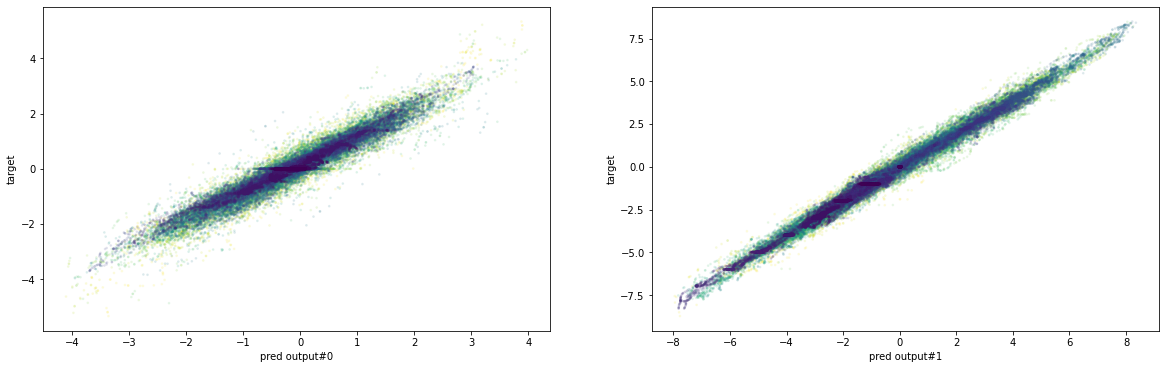

In [6]:


# Training of reference model
def update_step_ref(inputs_tr, targets_tr):
  with tf.GradientTape() as tape:
    outputs_tr = modelref(inputs_tr, num_processing_steps_ref)
    # Loss.
    loss_tr = create_loss_one(targets_tr, outputs_tr)
    
  gradients = tape.gradient(loss_tr, modelref.trainable_variables)
  optimizer.apply(gradients, modelref.trainable_variables)
  return outputs_tr, loss_tr

# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)
# How much time between logging and printing the current results.
log_every_seconds = 10


last_iteration = 0
start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  t = tf.random.uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
  input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
  target_nodes_tr = true_trajectory_tr[t + 1]

  outputs_tr_ref, loss_tr_ref = update_step_ref(input_graph_tr, target_nodes_tr)
  loss_tr_ref = tf.math.reduce_sum(loss_tr_ref) 
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:

    last_log_time = the_time
     
    elapsed = time.time() - start_time
      
    #logged_iterations.append(iteration)
    print("# {:05d}, T{:.1f}, Ltr{:.4f}" .format( iteration, elapsed, loss_tr_ref.numpy() ))
    
    
plot_corr(modelref,bfull=0)

In [7]:
#@title Set up model training and evaluation  { form-width: "30%" }
ops.reset_default_graph()

imp.reload(models)
# Create the model.

#model = models.FullEncodeProcessDecode(node_output_size=2)
#model = models.EncodeProcessDecode(num_units=32,num_layers=2, edge_output_size=2,node_output_size=5,global_output_size=1)

bfull=0
bnorm=1
model = models.Process(num_units=40,num_layers=2, edge_core_size=2,node_core_size=5,global_core_size=2,node_output_size=2)
#model = models.ProcessLoop(num_units=20,num_layers=2, edge_core_size=2,node_core_size=5,global_core_size=2,node_output_size=2)
model._core._network._node_block._use_sent_edges=True
model._core._network._node_block._sent_edges_aggregator = blocks.SentEdgesToNodesAggregator(tf.math.unsorted_segment_sum)

#bfull=1
#model = models.Identity(edge_output_size=2,node_output_size=5,global_output_size=2)

#bfull=1
#model = models.ProcessLoop(num_units=32,num_layers=2, edge_core_size=2,node_core_size=5,global_core_size=2,edge_output_size=2,node_output_size=5,global_output_size=1)



# 00116, T10.0, Ltr0.0927
# 00230, T20.1, Ltr0.1388
# 00344, T30.1, Ltr0.0844
# 00459, T40.2, Ltr0.0916
# 00573, T50.2, Ltr0.0725
# 00684, T60.2, Ltr0.0448
# 00795, T70.3, Ltr0.0153
# 00909, T80.3, Ltr0.0245
# 01023, T90.4, Ltr0.0051
# 01137, T100.4, Ltr0.0341
# 01252, T110.4, Ltr0.0050
# 01361, T120.5, Ltr0.0026
# 01475, T130.5, Ltr0.0080
# 01587, T140.6, Ltr0.0215
# 01700, T150.6, Ltr0.0117
# 01805, T160.6, Ltr0.0199
# 01910, T170.6, Ltr0.0118
# 02017, T180.6, Ltr0.0226
# 02123, T190.7, Ltr0.0041
# 02227, T200.8, Ltr0.0074
# 02333, T210.8, Ltr0.0036
# 02438, T220.9, Ltr0.0103
# 02545, T230.9, Ltr0.0060
# 02651, T241.0, Ltr0.0158
# 02761, T251.0, Ltr0.0171
# 02868, T261.1, Ltr0.0116
# 02974, T271.1, Ltr0.0138
# 03080, T281.2, Ltr0.0144
# 03193, T291.2, Ltr0.0157
# 03304, T301.3, Ltr0.0126
# 03415, T311.3, Ltr0.0076
# 03528, T321.4, Ltr0.0138
# 03641, T331.5, Ltr0.0089
# 03754, T341.5, Ltr0.0177
# 03867, T351.6, Ltr0.0128
# 03982, T361.6, Ltr0.0110
# 04096, T371.7, Ltr0.0178
# 04211, T

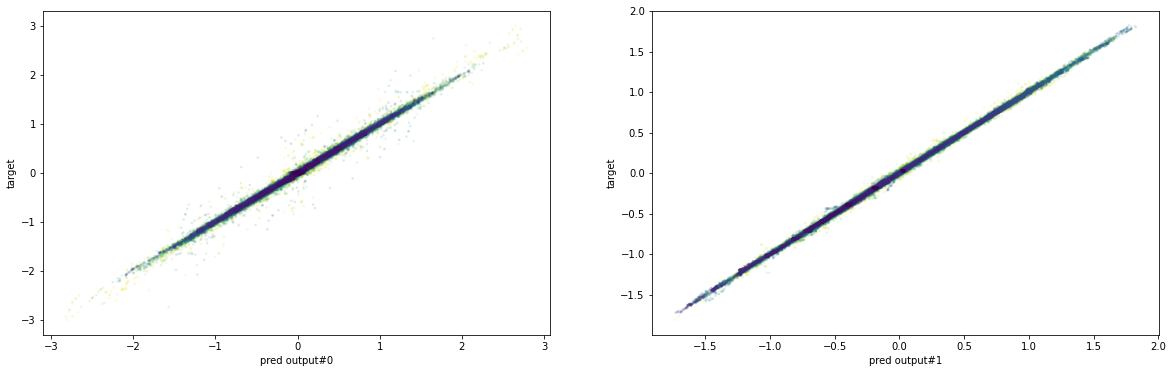

In [8]:
# Model parameters.
num_processing_steps_tr = 1
num_processing_steps_ge = num_processing_steps_tr
num_time_steps = 50
step_size = 0.1
dt=4
alpha=1.0
beta=0.1

def create_loss(target_op, output_op,target_op_dt, output_op_dt,):
  """Create supervised loss operations from targets and outputs.
     modified for tf2 
  
  losss = [
          tf.reduce_mean(tf.reduce_sum((output_op.nodes - target_op[..., 2:4])**2, axis=-1)) 
  ]
  """
  losss = [alpha*tf.reduce_mean((output_op - target_op)**2) + beta*tf.reduce_mean((output_op_dt - target_op_dt)**2)  ]
  return tf.stack(losss)


# Training of model
def update_step(inputs_tr, targets_tr, targets_tr_dt):
  with tf.GradientTape() as tape:
    outputs_tr = model(inputs_tr, num_processing_steps_tr)
    
    
    if bfull:           
        _, predicted_nodes_rollout_dt = roll_out_physics_wint(
            lambda x: model(x, num_processing_steps_tr),
            denormalize_graph(inputs_tr,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals),
            dt,        step_size, bnorm=bnorm)
    else:
        _, predicted_nodes_rollout_dt = roll_out_physics(
            lambda x: model(x, num_processing_steps_tr),
            denormalize_graph(inputs_tr,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals),
            dt,        step_size, bnorm=bnorm)

    predicted_nodes_rollout_dt=normalize_el(predicted_nodes_rollout_dt[-1],var_nodes,mean_nodes)
   
    
    # Loss.
    if bfull: 
        loss_tr = create_loss(targets_tr.nodes, outputs_tr.nodes,targets_tr_dt.nodes[..., 0:4],predicted_nodes_rollout_dt[..., 0:4])
        #+create_loss(targets_tr_dt, predicted_nodes_rollout_dt)  
    else:            
        loss_tr = create_loss(targets_tr.nodes[..., 2:4], outputs_tr.nodes,targets_tr_dt.nodes[..., 0:4],predicted_nodes_rollout_dt[..., 0:4])
        #+create_loss(targets_tr_dt, predicted_nodes_rollout_dt)  
 
  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return outputs_tr, loss_tr



# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)

# How much time between logging and printing the current results.
log_every_seconds = 10

last_iteration = 0
start_time = time.time()
last_log_time = start_time

initial_conditions_tr_norm=normalize_graph(initial_conditions_tr,var_nodes,mean_nodes,var_edges,mean_edges,var_globals,mean_globals)
        


for iteration in range(last_iteration,num_training_iterations  ):  #num_training_iterations
    
    
    
    last_iteration = iteration
    
    t = tf.random.uniform([], minval=0, maxval=num_time_steps - 1 -dt, dtype=tf.int32)
    input_graph_tr = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t],var_nodes,mean_nodes))
    target_graph_tr = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t+1],var_nodes,mean_nodes))  
    target_graph_tr_dt = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t+dt],var_nodes,mean_nodes))          
    '''
    for i in range(4):
        # create bias to initial steps
        if i<2:
            t = tf.random.uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
        else:
            t = tf.random.uniform([], minval=0, maxval=10, dtype=tf.int32)  

            
        if bnorm:
            if i>0:
                inp = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t],var_nodes,mean_nodes))
                tar = initial_conditions_tr_norm.replace(nodes=normalize_el(true_trajectory_tr[t+1],var_nodes,mean_nodes))
                input_graph_tr= utils_tf.concat([input_graph_tr,inp],axis=0)
                target_graph_tr = utils_tf.concat([target_graph_tr,tar],axis=0)
            else:
                input_graph_tr = initial_conditions_tr.replace(nodes=normalize_el(true_trajectory_tr[t],var_nodes,mean_nodes))
                target_graph_tr = initial_conditions_tr.replace(nodes=normalize_el(true_trajectory_tr[t+1],var_nodes,mean_nodes))  
        else:
            if i>0:
                inp = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
                tar = initial_conditions_tr.replace(nodes=true_trajectory_tr[t+1])
                input_graph_tr= utils_tf.concat([input_graph_tr,inp],axis=0)
                target_graph_tr = utils_tf.concat([target_graph_tr,tar],axis=0)
            else:
                input_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t])
                target_graph_tr = initial_conditions_tr.replace(nodes=true_trajectory_tr[t+1])  

    '''
    
      # i train model on normalized nodes 
      
  
  #this is to do pure autoencoding 
  #input_graph_tr = apply_noise(input_graph_tr,node_noise_level=0.0, edge_noise_level=0.001, global_noise_level=0.01)
  #target_graph_tr = input_graph_tr

  

    
    outputs_tr, loss_tr = update_step(input_graph_tr, target_graph_tr,target_graph_tr_dt)  
    
    loss_tr = tf.math.reduce_sum(loss_tr) 
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:

        last_log_time = the_time

        elapsed = time.time() - start_time

        #logged_iterations.append(iteration)
        print("# {:05d}, T{:.1f}, Ltr{:.4f}" .format( iteration, elapsed, loss_tr.numpy() ))

    
print('model parameters count')    
print(count_params(model))
print(count_params(modelref))
plot_corr(model,bfull=bfull,bnorm=bnorm)


6781
None
8178
None


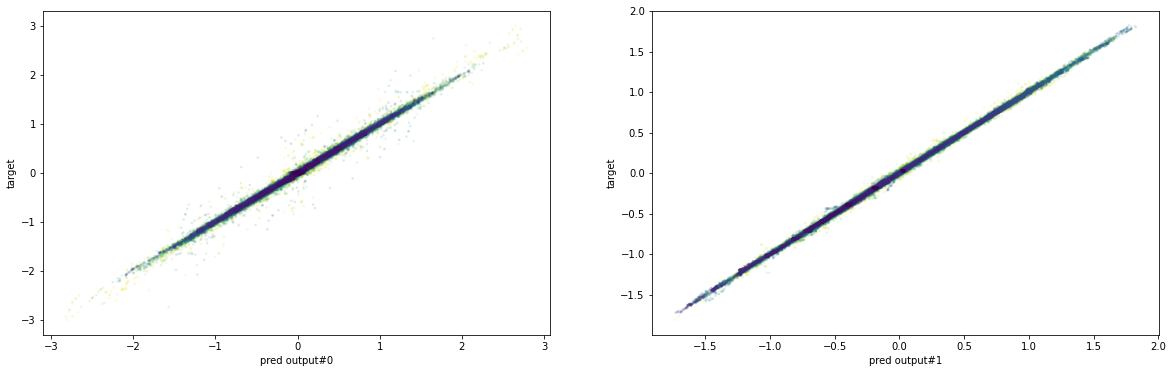

In [9]:
print(count_params(model))
print(count_params(modelref))
plot_corr(model,bfull=bfull,bnorm=bnorm)

In [10]:
# 4 and 9 masses apart test dataset

dist_between_masses_ge = rand.uniform(*dist_between_masses_min_max_tr, size=batch_size_ge)

base_graph_4_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(4, d) for d in dist_between_masses_ge ] )
# 9 masses 0.5m apart in a chain like structure.
base_graph_9_ge = utils_tf.data_dicts_to_graphs_tuple(
    [base_graph(9, d) for d in dist_between_masses_ge]  )

# Saving the base graph objects:
#with open('base_graphs'+suffix_pkl+'.pkl', 'wb') as f:  
#    pickle.dump([base_graph_9_ge, base_graph_4_ge], f)


In [26]:
base_graph_4_ge

GraphsTuple(nodes=<tf.Tensor: shape=(400, 5), dtype=float64, numpy=
array([[-0.85053247,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.42526624,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       ...,
       [-0.7583497 ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.7583497 ,  0.        ,  0.        ,  0.        ,  1.        ]])>, edges=<tf.Tensor: shape=(400, 2), dtype=float64, numpy=
array([[50.        ,  0.42526624],
       [50.        ,  0.42526624],
       [50.        ,  0.42526624],
       [50.        ,  0.42526624],
       [50.        ,  0.9933232 ],
       [50.        ,  0.9933232 ],
       [50.        ,  0.9933232 ],
       [50.        ,  0.9933232 ],
       [50.        ,  0.83972895],
       [50.        ,  0.83972895],
       [50.        ,  0.83972895],
       [50.        ,  0.83972895

In [58]:

#output_ops_tr = model(input_graph_tr, num_processing_steps_tr)
# train data rollout: 
initial_conditions_ge, true_trajectory_ge = generate_trajectory(
    simulator,
    base_graph_tr,
    num_time_steps,
    step_size,
    node_noise_level=0.0,
    edge_noise_level=0.0,
    global_noise_level=0.0)

_, true_nodes_rollout_ge = roll_out_physics(
    simulator, initial_conditions_ge, num_time_steps, step_size, bnorm)

if bfull:   
    _, predicted_nodes_rollout_ge = roll_out_physics_wint(
        lambda x: model(x, num_processing_steps_ge),
        initial_conditions_ge,        num_time_steps,        step_size, bnorm=bnorm)
else:
    _, predicted_nodes_rollout_ge = roll_out_physics(
        lambda x: model(x, num_processing_steps_ge),
        initial_conditions_ge,        num_time_steps,        step_size, bnorm=bnorm)

n_el=predicted_nodes_rollout_ge.shape[0]*predicted_nodes_rollout_ge.shape[1]*2
loss_op_tr = np.sqrt(tf.reduce_mean((predicted_nodes_rollout_ge[..., 2:4] -true_nodes_rollout_ge[..., 2:4])**2) )
print(loss_op_tr)

# Saving the objects:
#with open('rollout_model_tr'+suffix_pkl+'.pkl', 'wb') as f:  
#    pickle.dump([predicted_nodes_rollout_ge, true_nodes_rollout_ge,loss_op_tr], f)
   

3.708352338761942


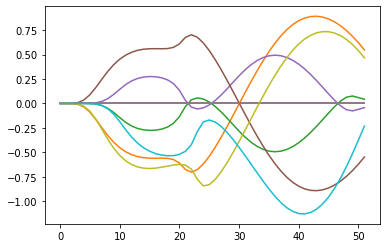

In [59]:
#notice bnorm is equal to 0

_, predicted_nodes_rollout_ref = roll_out_physics(
    lambda x: modelref(x, 1),
    initial_conditions_ge,        num_time_steps,        step_size)



loss_op_tr_ref = np.sqrt(tf.reduce_mean((predicted_nodes_rollout_ref[..., 2:4] -true_nodes_rollout_ge[..., 2:4])**2) )
print(loss_op_tr_ref)



# Saving the objects:
#with open('rollout_modelref_tr'+suffix_pkl+'.pkl', 'wb') as f:  
#    pickle.dump([predicted_nodes_rollout_ref, loss_op_tr_ref], f)
   


3.729104445885987


In [76]:

#Test data: 4-mass string.
initial_conditions_4_ge, true_trajectory_4_ge = generate_trajectory(
    simulator,
    base_graph_4_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.0,
    edge_noise_level=0.0,
    global_noise_level=0.0)

# Test data: 9-mass string.
initial_conditions_9_ge, true_trajectory_9_ge = generate_trajectory(
    simulator,
    base_graph_9_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.0,
    edge_noise_level=0.0,
    global_noise_level=0.0)


_, true_nodes_rollout_4_ge = roll_out_physics(
    simulator, initial_conditions_4_ge, num_time_steps, step_size)


if bfull:   
    _, predicted_nodes_rollout_4_ge = roll_out_physics_wint(
        lambda x: model(x, num_processing_steps_ge), base_graph_4_ge,
        num_time_steps, step_size,bnorm=bnorm)
else:
    _, predicted_nodes_rollout_4_ge = roll_out_physics(
        lambda x: model(x, num_processing_steps_ge), base_graph_4_ge,
        num_time_steps, step_size,bnorm=bnorm)

_, true_nodes_rollout_9_ge = roll_out_physics(
    simulator, initial_conditions_9_ge, num_time_steps, step_size)

if bfull:   
    _, predicted_nodes_rollout_9_ge = roll_out_physics_wint(
        lambda x: model(x, num_processing_steps_ge), base_graph_9_ge,
        num_time_steps, step_size,bnorm=bnorm)
else:
    _, predicted_nodes_rollout_9_ge = roll_out_physics(
    lambda x: model(x, num_processing_steps_ge), base_graph_9_ge,
    num_time_steps, step_size,bnorm=bnorm)


# Test/generalization loss: 4-mass.
loss_op_4_ge = np.sqrt(tf.reduce_mean(
        (predicted_nodes_rollout_4_ge[..., 2:4] -
         true_nodes_rollout_4_ge[..., 2:4])**2        ))
# Test/generalization loss: 9-mass string.
loss_op_9_ge = np.sqrt(tf.reduce_mean(    
        (predicted_nodes_rollout_9_ge[..., 2:4] -
         true_nodes_rollout_9_ge[..., 2:4])**2        ))


# obj0, obj1, obj2 are created here...

# Saving the objects:
#with open('rollout_test_model'+suffix_pkl+'.pkl', 'wb') as f:  
#    pickle.dump([predicted_nodes_rollout_ge, predicted_nodes_rollout_4_ge, predicted_nodes_rollout_9_ge, 
#                 true_nodes_rollout_ge, true_nodes_rollout_4_ge, true_nodes_rollout_4_ge,
#                loss_op_tr,loss_op_4_ge,loss_op_9_ge], f)
    
    

In [78]:
num_processing_steps_ge=1

#with open('base_graphs'+suffix_pkl+'.pkl','rb') as f: 
#    base_graph_9_ge, base_graph_4_ge = pickle.load(f)
    

_, predicted_nodes_rollout_4_ref = roll_out_physics(
    lambda x: modelref(x, num_processing_steps_ref), base_graph_4_ge,
    num_time_steps, step_size)


_, predicted_nodes_rollout_9_ref = roll_out_physics(
    lambda x: modelref(x, num_processing_steps_ref), base_graph_9_ge,
    num_time_steps, step_size)



# Test/generalization loss: 4-mass.
loss_op_4_ref = np.sqrt(tf.reduce_mean(
            (predicted_nodes_rollout_4_ref[..., 2:4] -
         true_nodes_rollout_4_ge[..., 2:4])**2        ))
# Test/generalization loss: 9-mass string.
loss_op_9_ref = np.sqrt(tf.reduce_mean(    
        (predicted_nodes_rollout_9_ref[..., 2:4] -
         true_nodes_rollout_9_ge[..., 2:4])**2        ))

# Saving the objects:
#with open('rollout_test_modelref'+suffix_pkl+'.pkl', 'wb') as f:  
#    pickle.dump([predicted_nodes_rollout_4_ref, predicted_nodes_rollout_9_ref, predicted_nodes_rollout_ref,
#                loss_op_tr_ref,loss_op_4_ref,loss_op_9_ref], f)
    
    

In [79]:

#with open('rollout_test_modelref'+suffix_pkl+'.pkl','rb') as f: 
#    predicted_nodes_rollout_4_ref, predicted_nodes_rollout_9_ref, predicted_nodes_rollout_ref,
#    loss_op_tr_ref,loss_op_4_ref,loss_op_9_ref = pickle.load(f)
    

#with open('rollout_test_model'+suffix_pkl+'.pkl','rb') as f:
#    predicted_nodes_rollout_ge, predicted_nodes_rollout_4_ge, predicted_nodes_rollout_9_ge, 
#    true_nodes_rollout_ge, true_nodes_rollout_4_ge, true_nodes_rollout_4_ge,
#    loss_op_tr,loss_op_4_ge,loss_op_9_ge = pickle.load(f)
    


test_values = {
        "loss_4": loss_op_4_ge,
        "true_rollout_4": true_nodes_rollout_4_ge,
        "predicted_rollout_4": predicted_nodes_rollout_4_ge,
        "predicted_rollout_4_ref": predicted_nodes_rollout_4_ref,
        "loss_9": loss_op_9_ge,
        "true_rollout_9": true_nodes_rollout_9_ge,
        "predicted_rollout_9": predicted_nodes_rollout_9_ge,
        "predicted_rollout_9_ref": predicted_nodes_rollout_9_ref}

print(loss_op_tr)
print(loss_op_4_ge)
print(loss_op_9_ge)
print(loss_op_tr_ref)
print(loss_op_4_ref)
print(loss_op_9_ref)

3.708352338761942
0.3333472409521457
0.7761198819160757
3.729104445885987
0.5163206630631868
1.7875048550016077


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


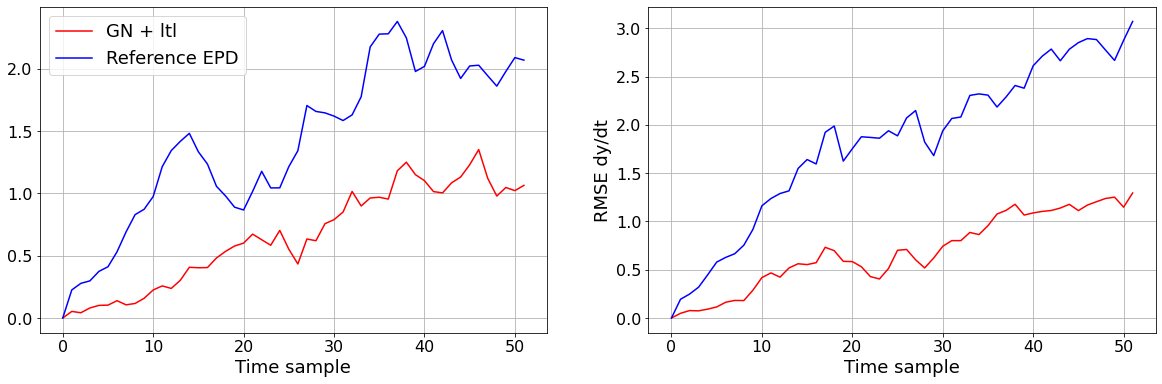

In [87]:

fig,ax=plt.subplots(1,2,figsize=(20,6))
ax[0].plot(np.sqrt(tf.reduce_mean( (true_nodes_rollout_9_ge[:,:, 2]-predicted_nodes_rollout_9_ge[:,:,2])**2,axis=(1))) ,'r',label='GN + ltl')
ax[0].plot(np.sqrt(tf.reduce_mean( (true_nodes_rollout_9_ge[:,:, 2]-predicted_nodes_rollout_9_ref[:,:,2])**2,axis=(1))) ,'b',label='Reference EPD')
ax[0].grid()
ax[0].set_xlabel('Time sample',fontsize=18)
ax[1].set_ylabel('RMSE dx/dt',fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].tick_params(axis='both', which='minor', labelsize=16)
ax[0].legend(fontsize=18)

ax[1].plot(np.sqrt(tf.reduce_mean( (true_nodes_rollout_9_ge[:,:, 3]-predicted_nodes_rollout_9_ge[:,:,3])**2,axis=(1))) ,'r',label='GN + ltl')
ax[1].plot(np.sqrt(tf.reduce_mean( (true_nodes_rollout_9_ge[:,:, 3]-predicted_nodes_rollout_9_ref[:,:,3])**2,axis=(1))) ,'b',label='Reference EPD')
ax[1].grid()
ax[1].set_xlabel('Time sample',fontsize=18)
ax[1].set_ylabel('RMSE dy/dt',fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='minor', labelsize=16)

fig.savefig( os.path.join('/home/dmsm/m.colombo/Images/Scitech 2023/MassSpringErr.eps'), format='eps')
#ax[0].plot(true_nodes_rollout_9_ge[:,0:100, 2],predicted_nodes_rollout_9_ref[:,0:100, 2] ,'r.',markersize=1 )
#ax[1].plot(true_nodes_rollout_9_ge[:,0:100, 3],predicted_nodes_rollout_9_ge[:,0:100,3] ,'b.',markersize=1)
#ax[1].plot(true_nodes_rollout_9_ge[:,0:100, 3],predicted_nodes_rollout_9_ref[:,0:100, 3] ,'r.',markersize=1 )
#ax[0].plot(true_nodes_rollout_9_ge[:,0:10, 2] ,'k' )


In [65]:
print(loss_op_4_ref/loss_op_4_ge)
print(loss_op_9_ref/loss_op_9_ge)

1.5488973647671744
2.3031298342578683


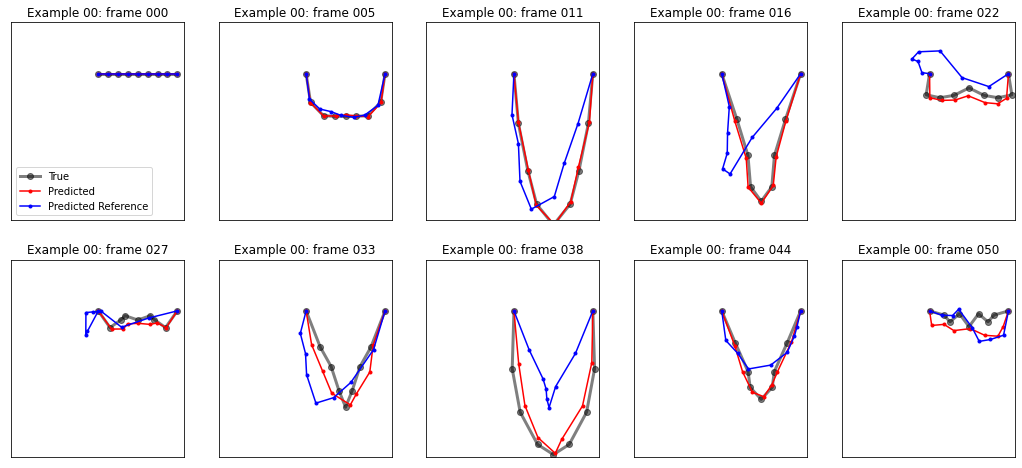

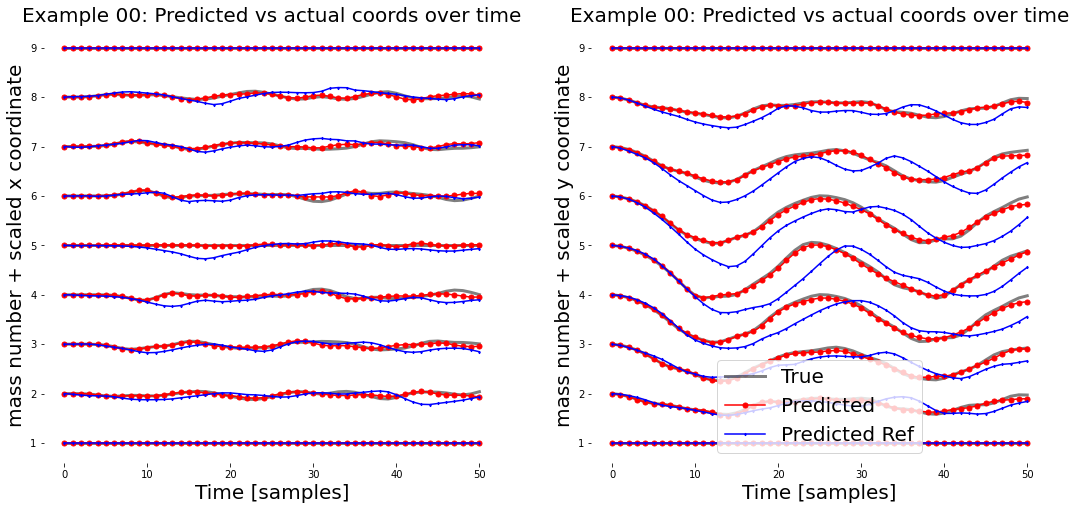

In [16]:

# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

def get_node_trajectories(rollout_array, batch_size):  # pylint: disable=redefined-outer-name
  return np.split(rollout_array[..., :2], batch_size, axis=1)

'''
fig = plt.figure(1, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Next-step Loss.
y = losses_tr
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y, "k")
ax.set_title("Next step loss")
# Rollout 5 loss.
y = losses_4_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 5-mass string")
# Rollout 9 loss.
y = losses_9_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y, "k")
ax.set_title("Rollout loss: 9-mass string")
'''
# Visualize trajectories.
true_rollouts_4 = get_node_trajectories(test_values["true_rollout_4"],
                                        batch_size_ge)
predicted_rollouts_4 = get_node_trajectories(test_values["predicted_rollout_4"],
                                             batch_size_ge)
predicted_rollouts_4_ref = get_node_trajectories(test_values["predicted_rollout_4_ref"],
                                             batch_size_ge)
true_rollouts_9 = get_node_trajectories(test_values["true_rollout_9"],
                                        batch_size_ge)
predicted_rollouts_9 = get_node_trajectories(test_values["predicted_rollout_9"],
                                             batch_size_ge)
predicted_rollouts_9_ref = get_node_trajectories(test_values["predicted_rollout_9_ref"],
                                             batch_size_ge)
'''
true_rollouts = true_rollouts_4
predicted_rollouts = predicted_rollouts_4
predicted_rollouts_ref = predicted_rollouts_4_ref
'''

true_rollouts = true_rollouts_9
predicted_rollouts = predicted_rollouts_9
predicted_rollouts_ref = predicted_rollouts_9_ref


num_graphs = len(true_rollouts)
num_time_steps = true_rollouts[0].shape[0]

# Plot state sequences.
max_graphs_to_plot = 1
num_graphs_to_plot = min(num_graphs, max_graphs_to_plot)
num_steps_to_plot = 10
max_time_step = num_time_steps - 1
step_indices = np.floor(np.linspace(0, max_time_step,
                                    num_steps_to_plot)).astype(int).tolist()
w = 5
h = int(np.ceil(num_steps_to_plot / w))
fig = plt.figure(101, figsize=(18, 8))
fig.clf()
for i, (true_rollout, predicted_rollout, predicted_rollout_ref) in enumerate(
    zip(true_rollouts, predicted_rollouts, predicted_rollouts_ref)):
  xys = np.hstack([predicted_rollout, true_rollout, predicted_rollout_ref]).reshape([-1, 3])
  xs = xys[:, 0]
  ys = xys[:, 1]
  ysref = xys[:, 2]
    
  b = 0.05
  xmin = xs.min() - b * xs.ptp()
  xmax = xs.max() + b * xs.ptp()
  ymin = ys.min() - b * ys.ptp()
  ymax = ys.max() + b * ys.ptp()
  if i >= num_graphs_to_plot:
    break
  for j, step_index in enumerate(step_indices):
    iax = i * w + j + 1
    ax = fig.add_subplot(h, w, iax)
    ax.plot(
        true_rollout[step_index, :, 0],
        true_rollout[step_index, :, 1],
        "k",
        linewidth=3,alpha=0.5,
        label="True",
        marker='o')
    
    ax.plot(
        predicted_rollout[step_index, :, 0],
        predicted_rollout[step_index, :, 1],
        "r",
        label="Predicted",
        marker='.')
    ax.plot(
        predicted_rollout_ref[step_index, :, 0],
        predicted_rollout_ref[step_index, :, 1],
        "b",
        label="Predicted Reference",
        marker='.')
    ax.set_title("Example {:02d}: frame {:03d}".format(i, step_index))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.legend(loc=3)

# Plot x and y trajectories over time.
max_graphs_to_plot = 1
num_graphs_to_plot = min(len(true_rollouts), max_graphs_to_plot)
w = 2
h = num_graphs_to_plot
fig = plt.figure(102, figsize=(18, 8*max_graphs_to_plot))
fig.clf()
for i, (true_rollout, predicted_rollout) in enumerate(
    zip(true_rollouts, predicted_rollouts)):
  if i >= num_graphs_to_plot:
    break
  t = np.arange(num_time_steps)
  for j in range(2):
    coord_string = "x" if j == 0 else "y"
    iax = i * 2 + j + 1
    ax = fig.add_subplot(h, w, iax)
     
    
    offset=np.arange(1,10)
    ax.plot(t, (true_rollout[..., j]- true_rollout[0,:, j])/5+offset, "k", label="True", linewidth=3,alpha=0.5)
    ax.plot(t, (predicted_rollout[..., j]-predicted_rollout[0,:, j])/5+offset, "r.-", label="Predicted",markersize=10)
    ax.plot(t, (predicted_rollout_ref[..., j]-predicted_rollout_ref[0,:, j])/5+offset, "bd-", label="Predicted Ref", markersize=1.8)
    ax.set_xlabel("Time [samples]" , fontsize=20)
    ax.set_ylabel("mass number + scaled {} coordinate".format(coord_string), fontsize=20)
    ax.set_title("Example {:02d}: Predicted vs actual coords over time".format(i), fontsize=20)
    ax.set_frame_on(False)
    if i == 0 and j == 1:
      handles, labels = ax.get_legend_handles_labels()
      unique_labels = []
      unique_handles = []
      for i, (handle, label) in enumerate(zip(handles, labels)):  # pylint: disable=redefined-outer-name
        if label not in unique_labels:
          unique_labels.append(label)
          unique_handles.append(handle)
      ax.legend(unique_handles, unique_labels, loc=8, fontsize=20)

FROM BELOW HERE IS ONLY TEST STUFF